<a href="https://www.kaggle.com/code/shellsquareganeshan/pneumonia-detection-from-chest-xray?scriptVersionId=187607717" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg                  # write image to folder
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # used for data augmentation when working with image data
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# take a look at the size of the dataset
test_normal_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL')
test_pneumonia_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA')
train_normal_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL')
train_pneumonia_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA')
val_normal_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL')
val_pneumonia_folder=os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA')

len(test_normal_folder),len(test_pneumonia_folder),len(train_normal_folder),len(train_pneumonia_folder),len(val_normal_folder),len(val_pneumonia_folder)

(234, 390, 1341, 3875, 8, 8)

In [3]:
# create a dataframe to store image path and their corresponding labels.
df = pd.DataFrame(columns=['path', 'label'])

In [4]:
# /kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg

In [5]:
# total length of the dataset
len(test_normal_folder)+len(test_pneumonia_folder)+len(train_normal_folder)+len(train_pneumonia_folder)+len(val_normal_folder)+len(val_pneumonia_folder)

5856

NOTE: As we looked earlier the dataset is not balanced so we need to combine all the images and form a new balanced dataset

In [6]:
# adding value to path column in dataframe df.
df = pd.DataFrame(columns=['path'])
main_path='/kaggle/input/chest-xray-pneumonia/chest_xray'
for i in ['test','train','val']:
    for j in ['NORMAL','PNEUMONIA']:
        sub_list=os.listdir(f'{main_path}/{i}/{j}')
        path_list=[f'{main_path}/{i}/{j}/{x}' for x in sub_list]
        new_df = pd.DataFrame(path_list, columns=['path'])
        df = pd.concat([df,new_df],ignore_index=True)

In [7]:
df.head()

,path
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [8]:
# adding value to label column in dataframe df.
df['label']=df['path'].str.split('/').str[-2]

In [9]:
df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [10]:
# add a new column folder to chech if we have correctly made the dataframe
df['folder']=df['path'].str.split('/').str[-3]

In [11]:
# all the data maches correctly as earlier.
print('test_normal',len(df.query('folder == "test" and label=="NORMAL"')))
print('test_pneumonia',len(df.query('folder == "test" and label=="PNEUMONIA"')))
print('train_normal',len(df.query('folder == "train" and label=="NORMAL"')))
print('train_pneumonia',len(df.query('folder == "train" and label=="PNEUMONIA"')))

test_normal 234
test_pneumonia 390
train_normal 1341
train_pneumonia 3875


In [12]:
# chech the size of the dataset and value count
len(df),df.label.value_counts()

(5856,
 label
 PNEUMONIA    4273
 NORMAL       1583
 Name: count, dtype: int64)

/tmp/ipykernel_26/1542865919.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


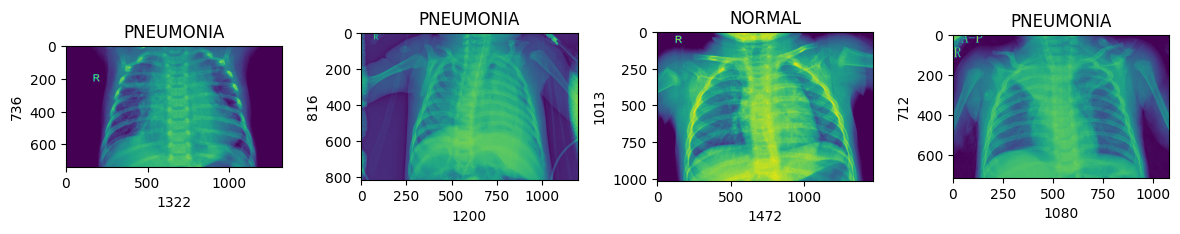

In [13]:
# lets take a look at some of the images at random
plt.figure(figsize=(12,12))
for i in range(1,5):              
    plt.subplot(1,4,i)              
    plt.tight_layout()
    path=df.path.sample(n=1).values[0]
    ran_img=imread(path) 
    plt.imshow(ran_img)
    plt.title(df.query('path == @path').label.item())
    plt.xlabel(ran_img.shape[1], fontsize=10)
    plt.ylabel(ran_img.shape[0], fontsize=10)

NOTE: As the normal labels are less compared to pneumonia label we can create a copy of the normal labeled images, perform a simple data transformation (horizontal flip) and add them back to the dataframe df to balance the dataset

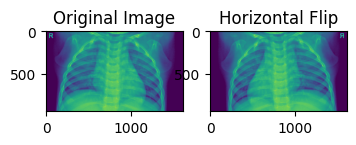

In [14]:
# sample example of data transformation

image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0336-0001.jpeg'
image = imread(image_path)
#  Display the original image
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)

# Horizontal flip (left to right)
horizontal_flip = np.flip(image, axis=1)

# Display the horizontally flipped image
plt.subplot(1, 3, 2)
plt.title("Horizontal Flip")
plt.imshow(horizontal_flip)

In [15]:
# copy rows with NORMAL as label
df_normal=df.query('label=="NORMAL"')
df_normal.head(10),df_normal.shape

(                                                path   label folder
 0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 5  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 6  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 7  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 8  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test
 9  /kaggle/input/chest-xray-pneumonia/chest_xray/...  NORMAL   test,
 (1583, 3))

In [16]:
# create a folder to store the transformed data
folder_name = 'balancing_image'
folder_path = os.path.join('/kaggle/working', folder_name)
os.makedirs(folder_path, exist_ok=True)

In [17]:
# transforming each image and storing it in the folder created
n=0 
for path in tqdm(df_normal.path.values):
    image = imread(path)
    horizontal_flip = np.flip(image, axis=1)
    # Specify the output file path and name for the flipped image
    output_image_path = f'/kaggle/working/balancing_image/normal{n}.jpeg'
    # Save the horizontally flipped image using mpimg.imsave()
    n=n+1
    mpimg.imsave(output_image_path, horizontal_flip)

100%|██████████| 1583/1583 [02:03<00:00, 12.81it/s]


In [18]:
# os.remove(image_path)

# checking the size and name's of the image
flip_img_list=os.listdir('/kaggle/working/balancing_image')
len(flip_img_list),flip_img_list[:2]

(1583, ['normal1253.jpeg', 'normal119.jpeg'])

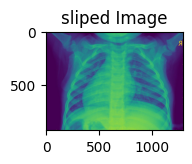

In [19]:
# take a look at the sliped image 
image_path = '/kaggle/working/balancing_image/normal1580.jpeg'
image = imread(image_path)
plt.figure(figsize=(6, 6))
plt.subplot(1, 3, 1)
plt.title("sliped Image")
plt.imshow(image)

In [20]:
# modifing the paths of the transformed data to add it to the datafrane df
preffix='/kaggle/working/balancing_image/'
path_list = [preffix+item for item in flip_img_list]
# path_list[:10]
new_df = pd.DataFrame(path_list, columns=['path'])
new_df['label']='NORMAL'
new_df.head(5)

,path,label
0,/kaggle/working/balancing_image/normal1253.jpeg,NORMAL
1,/kaggle/working/balancing_image/normal119.jpeg,NORMAL
2,/kaggle/working/balancing_image/normal1170.jpeg,NORMAL
3,/kaggle/working/balancing_image/normal937.jpeg,NORMAL
4,/kaggle/working/balancing_image/normal1019.jpeg,NORMAL


In [21]:
df = pd.concat([df,new_df],ignore_index=True)
# take a look at the size of the dataset and valuecount of the label
len(df),df.label.value_counts()

(7439,
 label
 PNEUMONIA    4273
 NORMAL       3166
 Name: count, dtype: int64)

In [22]:
# no need of this column only used for checking
df.drop('folder',axis=1,inplace=True)

In [23]:
# spliting the data to train(70%),test(10%), val(20%)
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.18, random_state=42)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [24]:
train.label.value_counts(),test.label.value_counts()

(label
 PNEUMONIA    3168
 NORMAL       2321
 Name: count, dtype: int64,
 label
 PNEUMONIA    400
 NORMAL       344
 Name: count, dtype: int64)

In [25]:
# train, val and test size
len(train),len(val),len(test)

(5489, 1206, 744)

In [26]:
# Create Image Data Generator for Train Set,val set and test set
train_data_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
val_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [27]:
train_generator = train_data_gen.flow_from_dataframe(
      dataframe=train,
      x_col='path', 
      y_col='label',
      color_mode='grayscale',
      class_mode='binary',
      batch_size=32
      )
val_generator = val_data_gen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col='label',
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  
)

test_generator = test_data_gen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='label',
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  
)

Found 5489 validated image filenames belonging to 2 classes.
Found 1206 validated image filenames belonging to 2 classes.
Found 744 validated image filenames belonging to 2 classes.


In [28]:
train_generator.image_shape,train_generator.labels.count(1)

((256, 256, 1), 3168)

In [29]:
# shape of image in val and also size of val
val_generator.image_shape,val_generator.labels.count(0)+val_generator.labels.count(1)

((256, 256, 1), 1206)

In [30]:
# create the cnn model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

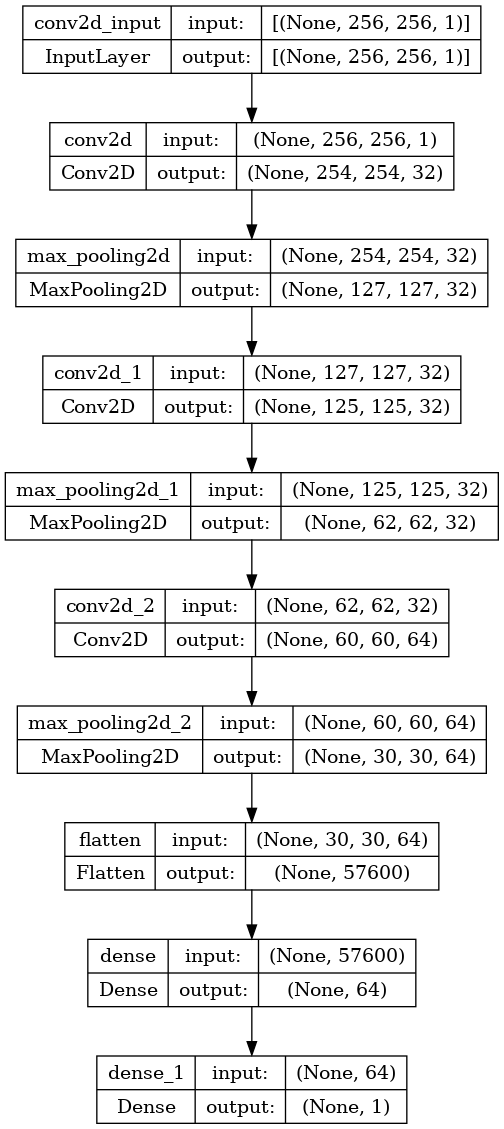

In [31]:
# plot the model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [32]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history=model.fit(train_generator,epochs=25, validation_data=val_generator, callbacks=[early_stopping_callback])

Epoch 1/25
172/172 [==============================] - 102s 566ms/step - loss: 0.4411 - accuracy: 0.7876 - val_loss: 0.2156 - val_accuracy: 0.9163
Epoch 2/25
172/172 [==============================] - 79s 460ms/step - loss: 0.2742 - accuracy: 0.8923 - val_loss: 0.1567 - val_accuracy: 0.9378
Epoch 3/25
172/172 [==============================] - 78s 453ms/step - loss: 0.2576 - accuracy: 0.8987 - val_loss: 0.1902 - val_accuracy: 0.9237
Epoch 4/25
172/172 [==============================] - 78s 454ms/step - loss: 0.2204 - accuracy: 0.9195 - val_loss: 0.1288 - val_accuracy: 0.9585
Epoch 5/25
172/172 [==============================] - 78s 452ms/step - loss: 0.2241 - accuracy: 0.9151 - val_loss: 0.1325 - val_accuracy: 0.9519
Epoch 6/25
172/172 [==============================] - 76s 443ms/step - loss: 0.2179 - accuracy: 0.9136 - val_loss: 0.2430 - val_accuracy: 0.8947
Epoch 7/25
172/172 [==============================] - 76s 444ms/step - loss: 0.2058 - accuracy: 0.9209 - val_loss: 0.1263 - val_a

In [33]:
# convert model evaluatoin to dataframe for ploting
re = pd.DataFrame(history.history)
re.head()

,loss,accuracy,val_loss,val_accuracy
0,0.441050,0.787575,0.215572,0.916252
1,0.274202,0.892330,0.156744,0.937811
2,0.257602,0.898706,0.190216,0.923715
3,0.220439,0.919475,0.128762,0.958541
4,0.224070,0.915103,0.132494,0.951907


In [34]:
# evaluate model with test data
test_accu = model.evaluate(test_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')
# lets manually evaluate the test data
preds = model.predict(test_generator,verbose=1)

24/24 [==============================] - 8s 326ms/step - loss: 0.1840 - accuracy: 0.9247
The testing accuracy is : 92.4731194972992 %
24/24 [==============================] - 6s 241ms/step


In [35]:
# converting the prediction in preds to labels 
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [36]:
# take a look at y_pred,y_actual
predictions.flatten().tolist()[:5] , test_generator.classes[:5]

([0.0, 0.0, 0.0, 1.0, 0.0], [0, 0, 0, 1, 0])

In [37]:
# check accuracy of test_predicted and test_actual with accuracy_score() 
accuracy = accuracy_score(test_generator.classes, predictions.flatten().tolist())
print("Accuracy:", accuracy)

Accuracy: 0.9247311827956989


NOTE: The easy way to interpret the confusion matrix for binary or multiclass classification is to see if we get maximum values in diagonal cells from left to right and minimum value in the rest of the cells.

<Axes: >

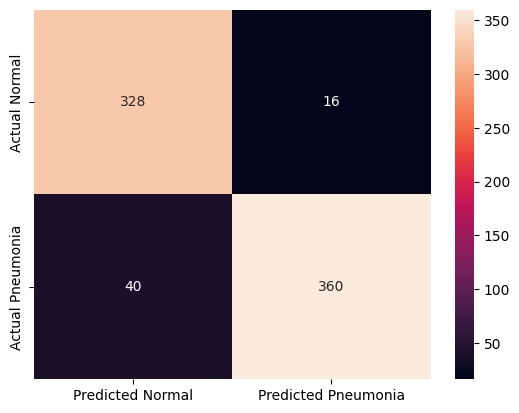

In [38]:
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
sns.heatmap(cm,annot=True,fmt="d")

<Axes: >

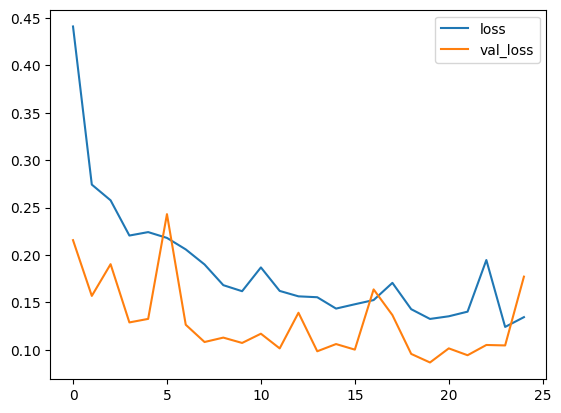

In [39]:
re[['loss','val_loss']].plot()

<Axes: >

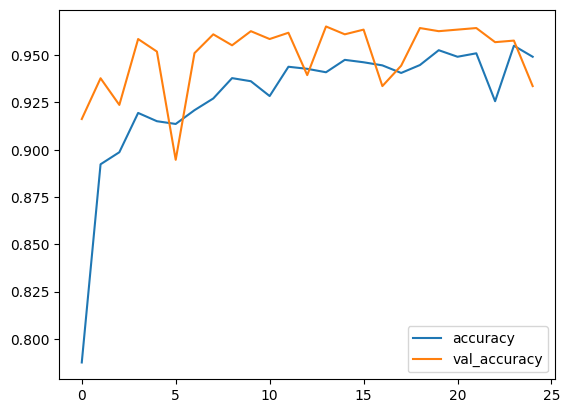

In [40]:
re[['accuracy','val_accuracy']].plot()